In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs 

### plotting 
from matplotlib import pyplot as plt
import seaborn as sns

### dask 
from dask.diagnostics import ProgressBar

In [3]:
import dask

### paths 

In [4]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### load local libraries 

In [5]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [6]:
sys.path.append('../../') 

In [7]:
from ICU_Water_Watch import geo, C3S, domains, plot, verification

### import libraries for validation

In [8]:
import climpred
from climpred import HindcastEnsemble
import xskillscore as xs

### parameters for papermill 

In [9]:
verif_dset = 'ERA'
quantile = 'tercile'
varname = 'TPRATE'
GCM = 'ECMWF'
period = 'monthly'

In [10]:
dict_quantiles = {}
dict_quantiles['tercile'] = [0.3333,  0.6666]
dict_quantiles['quartile'] = [0.25, 0.50, 0.75]

## reads the verification dataset 

In [11]:
if verif_dset == 'MSWEP': 
    verif, verif_anomalies = verification.get_mswep()
elif verif_dset == 'CMAP': 
    verif, verif_anomalies = verification.get_cmap()
    verif = verif.drop('ndays')
    verif_anomalies = verif_anomalies.drop('ndays')
elif verif_dset == 'ERA': 
    verif, verif_anomalies = verification.get_era5()

In [12]:
verif = verif.clip(min=0)

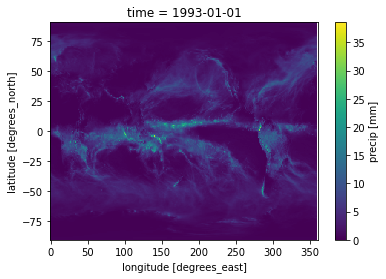

In [13]:
verif['precip'][0,:,:].plot()

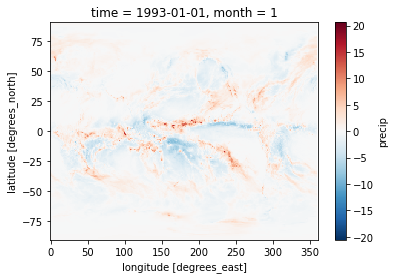

In [14]:
verif_anomalies['precip'][0,:,:].plot()

### we don't need the anomalies, so we close 

In [15]:
verif_anomalies.close()

In [16]:
del(verif_anomalies)

### selects the domain 

In [17]:
domain = domains.domains['Water_Watch']

In [18]:
verif = verif.sel(lat=slice(*domain[2:]), lon=slice(*domain[:2]))

## calculates the seasonal accumulations 

In [19]:
if period == 'seasonal': 
    verif = verif.rolling({'time':3}, min_periods=3).sum('time')
    verif = verif.isel(time=slice(2, None))

### calculates the quantiles 

### first rechunks

In [20]:
verif = verif.chunk({'time':-1, 'lat':10, 'lon':10})

In [21]:
monthly_quantile_climatology_verif = verif.groupby(verif['time'].dt.month).quantile(dict_quantiles[quantile], dim='time')

In [22]:
monthly_quantile_climatology_verif

,Array,Chunk
Bytes,1.30 MiB,1.56 kiB
Shape,"(12, 2, 61, 116)","(1, 2, 10, 10)"
Count,11697 Tasks,1008 Chunks
Type,float64,numpy.ndarray


In [23]:
def get_OBS_category_digitize(dset, clim_quantiles, varname='precip', dim='quantile'): 
    import numpy as np 
    import xarray as xr
    try: 
        import dask 
    except ImportError("dask is not available ..."):
        pass 
    
    def _digitize(x, bins):
        return np.digitize(x.ravel(), bins.ravel())
    
    categories = xr.apply_ufunc(_digitize, dset[varname], clim_quantiles[varname], input_core_dims=[[], [dim]],
                vectorize=True, dask='parallelized')
    
    # add one so that the categories go from 1 to N_categories + 1 
    categories += 1
    
    return categories

In [24]:
verif_quantile_categories = []

for date in verif.time:
    
    x = verif.sel(time=date)
    
    month = date.dt.month.data
    
    clim_quantile = monthly_quantile_climatology_verif.sel(month=month)
    
    quantile_category = get_OBS_category_digitize(x, clim_quantile, varname='precip', dim='quantile')
    
    quantile_category = quantile_category.expand_dims({'time':[date.data]})
    
    verif_quantile_categories.append(quantile_category)

In [25]:
verif_quantile_categories = xr.concat(verif_quantile_categories, dim='time')

In [26]:
verif_quantile_categories = verif_quantile_categories.to_dataset(name='precip')

In [27]:
verif_quantile_categories

,Array,Chunk
Bytes,15.55 MiB,800 B
Shape,"(288, 61, 116)","(1, 10, 10)"
Count,183057 Tasks,24192 Chunks
Type,int64,numpy.ndarray


### save the monthly or seasonal quantile categories to disk 

In [28]:
CWD

PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/notebooks/verification')

In [29]:
opath_verif_categories = CWD.parents[1].joinpath(f"outputs/{verif_dset}_{quantile}_categories")

In [30]:
print(str(opath_verif_categories))

/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/ERA_tercile_categories


In [31]:
if not(opath_verif_categories.exists()): 
    opath_verif_categories.mkdir()

### saves to disk in ZARR format

In [32]:
verif_quantile_categories.to_zarr(opath_verif_categories.joinpath(f"{verif_dset}_{quantile}_{period}_categories.zarr"), mode='w')